In [4]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm_notebook

# Gradient boosting
from catboost import CatBoostRegressor, Pool

# Feature importances / shapley values
import shap

# 1. Reading in both the training and testing data

In [5]:
train_df = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])

/home/giles/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_df.head(5)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,...,32.385708,83.036750,73.03241,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,...,32.385708,83.015045,73.03241,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,...,32.385708,83.015045,73.03241,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,...,32.385708,83.036750,73.03241,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,...,32.385708,83.015045,73.03241,45.398197,44.334373,False,0.0,False,0.0,False


In [7]:
test_df.head(5)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,
0,20000,427,pre_rinse,2018-04-30 21:39:21,L4,17039.207,0.480035,13.726129,0.337567,0.018084,...,29.922598,82.94994,72.526050,45.378080,45.124700,False,0.0,False,0.0,False
1,20000,427,pre_rinse,2018-04-30 21:39:23,L4,29390.912,0.554253,13.852720,0.335876,0.025318,...,29.922598,83.01143,72.526050,45.385216,45.125390,False,0.0,False,0.0,False
2,20000,427,pre_rinse,2018-04-30 21:39:25,L4,24323.640,0.657118,13.939526,0.335706,0.025318,...,29.922598,83.07292,72.529655,45.383460,45.125343,False,0.0,False,0.0,False
3,20000,427,pre_rinse,2018-04-30 21:39:27,L4,17180.266,0.749132,14.001014,0.335571,0.025318,...,29.944302,83.07292,72.526050,45.375385,45.125360,False,0.0,False,0.0,False
4,20000,427,pre_rinse,2018-04-30 21:39:29,L4,11754.919,0.795139,14.001014,0.335509,0.028935,...,29.922598,83.08739,72.529655,45.374237,45.121326,False,0.0,False,0.0,False


In [8]:
# The test set does not contain data of the final rinse phase
train_df = train_df[train_df.phase != 'final_rinse']

# 2. Make the distribution of number of phases per process more similar

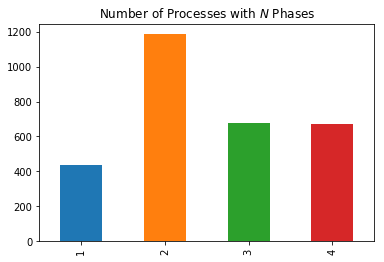

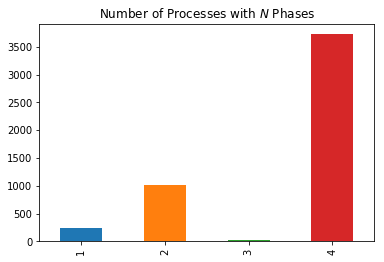

In [9]:
test_df.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

train_df.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

In [14]:
# This is the distribution as listed on the wegbage
fraction_per_phase = {
    'pre_rinse': 0.1,
    'caustic': 0.3,
    'intermediate_rinse': 0.35,
    'acid': 0.25
}

phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']

sampled_data = None

all_processes = set(train_df['process_id'])

# Iterate over the different phases
for i in range(len(phases)):
    # Get all the data belonging to that phase
    phase = phases[i]
    phase_values = train_df[train_df['phase'] == phase]
    phase_processes = set(phase_values['process_id'])
    
    # Now sample from the intersection of phase_processes and all_processes
    intersect = list(all_processes.intersection(phase_processes))
    sample = np.random.choice(intersect,
                              replace=False,
                              size=int(fraction_per_phase[phase] * len(all_processes)))
    
    # Remove the sampled processed from all_processes
    all_processes -= set(sample)
    
    # Now get all data records that correspond to the sampled process id's
    # up until the appropriate phase
    sample_df = train_df[(train_df['process_id'].isin(sample)) & 
                         (train_df['phase'].isin(phases[:i+1]))]
    
    if sampled_data is None:
        sampled_data = sample_df
    else:
        sampled_data = pd.concat([sampled_data, sample_df])
        
# Now add the remaining processes to the sampled_data
remaining_data = train_df[train_df['process_id'].isin(all_processes)]
sampled_data = pd.concat([sampled_data, remaining_data])

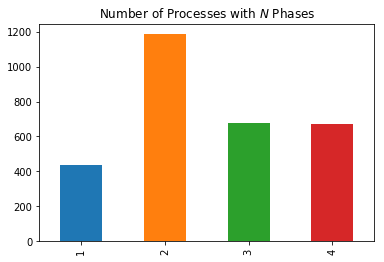

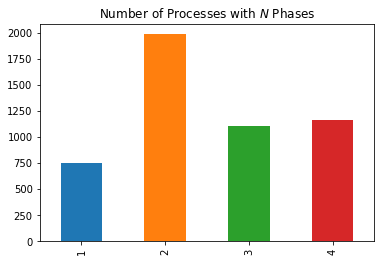

5005


In [17]:
test_df.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

sampled_data.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

print(sampled_data['process_id'].nunique())

# 3. Generating some basic features:
* One-hot-encode the pipeline, removing L_12 since that does not appear in the test set
* Count the number of phases
* For each real-valued timeseries: calculate mean, min, max, std and median of the entire timeseries
* For the real-valued timeseries: also calculate the mean and std of the final 5 values of every phase
* For each binary-valued timeseries: calculate fraction of True (sum / len)

In [37]:
def encode_categorical(df):
    # Currently just copy-pasted from http://drivendata.co/blog/rinse-over-run-benchmark/
    
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data (so useless feature)
    if 'pipeline_L12' in meta:
        meta = meta.drop('pipeline_L12', axis=1)
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level'
]

# phases, ordered from earliest to latest
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']


def encode_real_timeseries(df):   
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', 'count', 'median'])
    
    # Now we will get the mean + variance value of the last K measurements for each phase
    all_vals_per_phase = []
    K = 5
    col_names = ['process_id'] 
    for phase in phases:
        for col in ts_cols:
            col_names.extend(['mean_{}_{}_{}'.format(col, K, phase), 
                              'std_{}_{}_{}'.format(col, K, phase)])
    for process in tqdm_notebook(ts_features.index, total=len(ts_features)):
        vals_per_phase = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase].tail(K)
            for col in ts_cols:
                vals_per_phase.extend([filtered_df[col].mean(), filtered_df[col].std()])
                
        all_vals_per_phase.append(vals_per_phase)
    values_df = pd.DataFrame(all_vals_per_phase, columns=col_names)
    values_df = values_df.set_index('process_id')
    
    ts_features = ts_features.merge(values_df, left_index=True, right_index=True)
    
    return ts_features

def encode_binary_timeseries(df):
    # TODO: Count fraction of True in each phase
    feature_vectors = []
    col_names = ['process_id'] 
    for phase in phases:
        for col in bin_cols:
            col_names.append('fraction_{}_{}'.format(col, phase))
            
    # Get fraction of True values for each binary timeseries
    for process in tqdm_notebook(set(df['process_id']), total=len(set(df['process_id']))):
        vector = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase]
            for col in bin_cols:
                if len(filtered_df):
                    vector.append(sum(filtered_df[col]) / len(filtered_df))
                else:
                    vector.append(np.NaN)
                
        feature_vectors.append(vector)
                
    feature_df = pd.DataFrame(feature_vectors, columns=col_names)
    feature_df = feature_df.set_index('process_id')
    
    return feature_df

def create_feature_matrix(df):
    metadata = encode_categorical(df)
    time_series = encode_real_timeseries(df)
    binary_features = encode_binary_timeseries(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = metadata
    feature_matrix = feature_matrix.merge(time_series, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(binary_features, left_index=True, right_index=True)
    
    return feature_matrix

In [38]:
train_features = create_feature_matrix(sampled_data)
train_features.to_csv('data/train_features.csv')

/home/giles/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


KeyboardInterrupt: 

In [ ]:
print(train_features.shape)
train_features.head()

In [21]:
test_features = create_feature_matrix(test_df)
test_features.to_csv('data/test_features.csv')

In [22]:
print(test_features.shape)
test_features.head()

(2967, 254)


,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,...,fraction_supply_pump_acid,fraction_supply_pre_rinse_acid,fraction_supply_caustic_acid,fraction_return_caustic_acid,fraction_supply_acid_acid,fraction_return_acid_acid,fraction_supply_clean_water_acid,fraction_return_recovery_water_acid,fraction_return_drain_acid,fraction_object_low_level_acid
process_id,,,,,,,,,,,,,,,,,,,,,
20000,0,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20006,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20007,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20009,0,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20010,0,0,0,0,0,0,0,1,0,0,...,0.94636,0.0,0.0,0.390805,0.942529,0.590038,0.015326,0.019157,0.0,0.011494


# 4. Fit a gradient boosting model. Take 10% randomly from the training set, which is used as validation set and stop the training when the error increases on that set. We predict the logarithm of the label instead of the real label to squash the labels a bit more together. **DO NOT FORGET TO TAKE THE EXP OF THE PREDICTIONS!!!!**

In [25]:
all_labels = pd.read_csv('data/train_labels.csv', index_col=['process_id'])

train_idx = np.random.choice(train_features.index, replace=False, size=int(0.9 * len(train_features)))
val_idx = list(set(train_features.index) - set(train_idx))

X_train = train_features.loc[train_idx, :]
X_val = train_features.loc[val_idx, :]
y_train = np.log(all_labels.loc[train_idx])
y_val = np.log(all_labels.loc[val_idx])

del train_features # We do not need this anymore, saving some memory here

In [28]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)

In [30]:
cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.1,
                        loss_function='MAPE', eval_metric=MAPEMetric())
cat.fit(Pool(X_train, y_train), eval_set=[Pool(X_val, y_val)], verbose=50)

0:	learn: 0.8746767	test: 0.8847348	best: 0.8847348 (0)	total: 174ms	remaining: 4h 50m 22s
50:	learn: 0.8746760	test: 0.8847340	best: 0.8847340 (50)	total: 9.02s	remaining: 4h 54m 36s
100:	learn: 0.8746749	test: 0.8847330	best: 0.8847330 (100)	total: 17.7s	remaining: 4h 52m 33s
150:	learn: 0.8746732	test: 0.8847314	best: 0.8847314 (150)	total: 23.1s	remaining: 4h 14m 6s
200:	learn: 0.8746708	test: 0.8847290	best: 0.8847290 (200)	total: 25.3s	remaining: 3h 29m 4s
250:	learn: 0.8746671	test: 0.8847255	best: 0.8847255 (250)	total: 27.2s	remaining: 3h 15s
300:	learn: 0.8746617	test: 0.8847203	best: 0.8847203 (300)	total: 29s	remaining: 2h 40m 6s
350:	learn: 0.8746537	test: 0.8847126	best: 0.8847126 (350)	total: 31.2s	remaining: 2h 27m 26s
400:	learn: 0.8746419	test: 0.8847013	best: 0.8847013 (400)	total: 33.8s	remaining: 2h 20m 4s
450:	learn: 0.8746242	test: 0.8846846	best: 0.8846846 (450)	total: 35.7s	remaining: 2h 11m 29s
500:	learn: 0.8745980	test: 0.8846598	best: 0.8846598 (500)	total:

4250:	learn: 0.2368023	test: 0.3040325	best: 0.3039475 (4246)	total: 9m 53s	remaining: 3h 42m 51s
4300:	learn: 0.2353463	test: 0.3037044	best: 0.3037044 (4300)	total: 10m 2s	remaining: 3h 43m 25s
4350:	learn: 0.2339989	test: 0.3038020	best: 0.3036856 (4311)	total: 10m 11s	remaining: 3h 44m 6s
4400:	learn: 0.2324805	test: 0.3036150	best: 0.3035929 (4396)	total: 10m 20s	remaining: 3h 44m 28s
4450:	learn: 0.2310587	test: 0.3035827	best: 0.3035827 (4450)	total: 10m 29s	remaining: 3h 45m 3s
4500:	learn: 0.2295425	test: 0.3033535	best: 0.3032707 (4497)	total: 10m 38s	remaining: 3h 45m 57s
4550:	learn: 0.2279920	test: 0.3032123	best: 0.3030691 (4524)	total: 10m 47s	remaining: 3h 46m 23s
4600:	learn: 0.2265485	test: 0.3030991	best: 0.3030149 (4584)	total: 10m 56s	remaining: 3h 46m 49s
4650:	learn: 0.2252270	test: 0.3029270	best: 0.3028814 (4632)	total: 11m 6s	remaining: 3h 47m 39s
4700:	learn: 0.2237840	test: 0.3027942	best: 0.3027694 (4683)	total: 11m 15s	remaining: 3h 48m 21s
4750:	learn: 0.

# 5. Plot the insights learned by the model, and make predictions

In [31]:
shap.initjs()

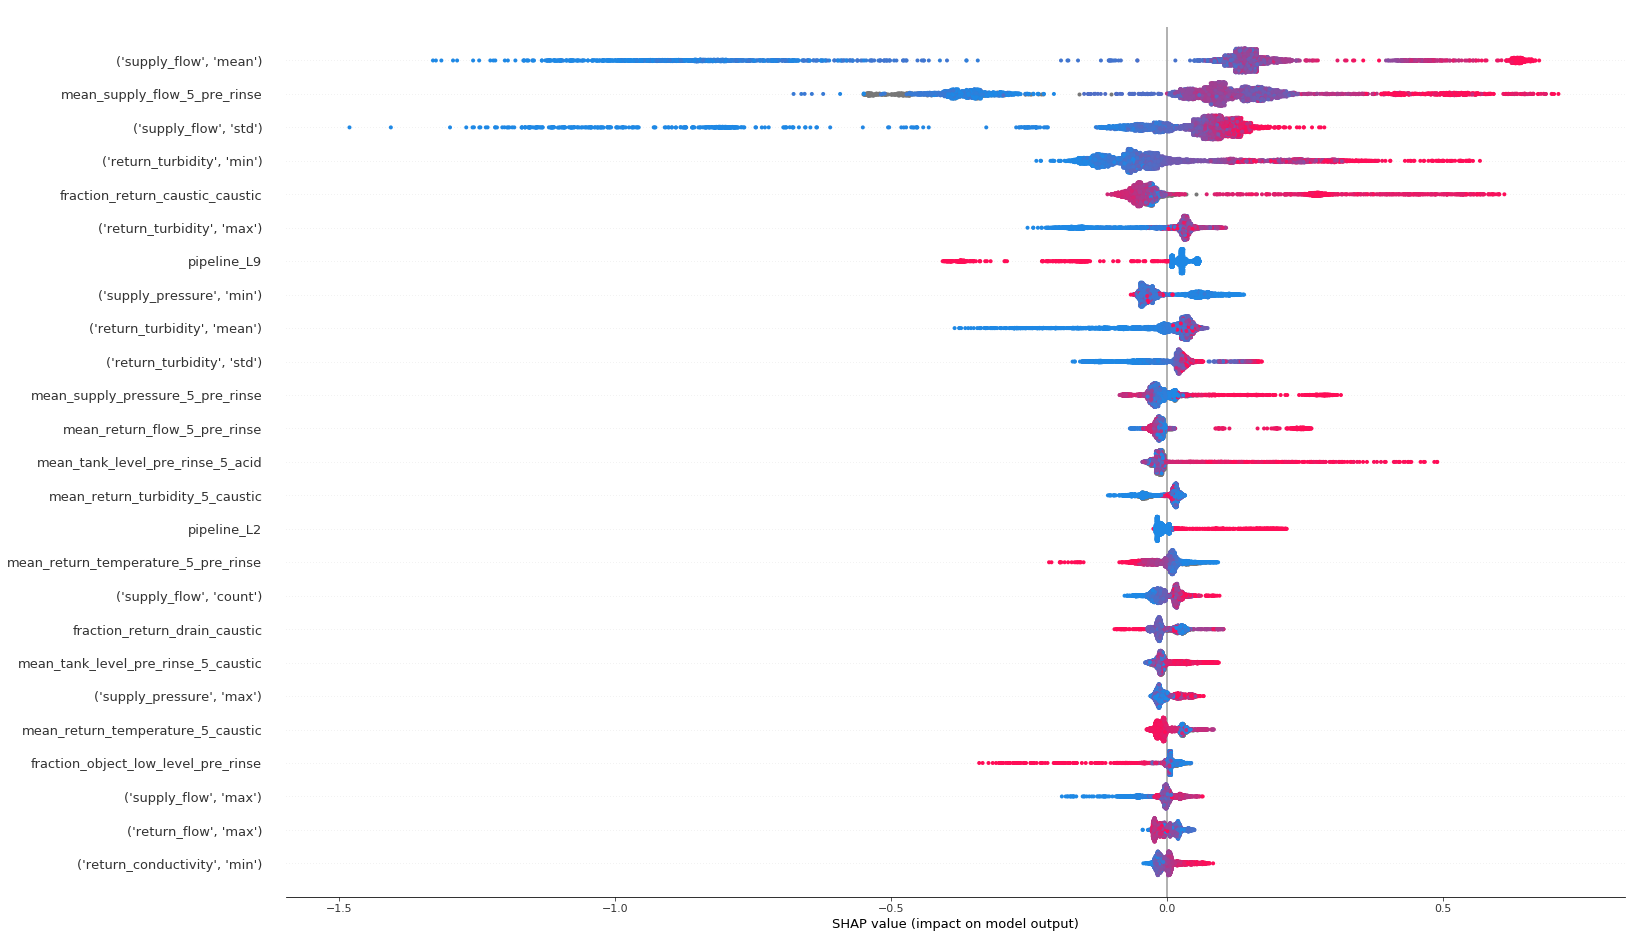

In [32]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=25, 
                  auto_size_plot=True, show=False, color_bar=False)
plt.gcf().set_size_inches(24, 16)
plt.show()

In [33]:
X_test = test_features

predictions = np.exp(cat.predict(X_test))

predictions_df = pd.DataFrame(predictions, columns=['final_rinse_total_turbidity_liter'])
predictions_df.index = X_test.index
predictions_df.index.name = X_test.index.name
predictions_df.to_csv('baseline_adversarial_validation.csv')

CatboostError: catboost/libs/data_new/model_dataset_compatibility.cpp:154: Feature pipeline_L2 from pool must be pipeline_L12.

In [36]:
X_test.values.shape, X_train.values.shape

((2967, 254), (4504, 255))